In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import sys 
sys.path.append("//home/mounika//Documents//IUPUI//Courses//Deep Learning //Project//DDD_copy")
import os
import glob
import logging
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Load and prepare dataset
# resample value
ir_val = '100ms'
# step size
n_steps = 20

In [3]:
# Code Tune
logging.getLogger().setLevel(logging.INFO)

csv_pick_regex= r'6*_[5,0].csv'
csv_pick_regex= r'6*.csv'

In [4]:
# Table Tune
face_points_to_keep = []
face_points_to_keep += [9]                     # Nose
face_points_to_keep += [37,38,39,40,41,42]     # Left Eye
face_points_to_keep += [43,44,45,46,47,48]     # Right Eye
face_points_to_keep += [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] # Outer Lip

In [5]:
columns_to_keep = ['participant', 'mood', 'time'] + \
                    [f'px_{x}' for x in face_points_to_keep] + \
                    [f'py_{x}' for x in face_points_to_keep] +\
                    ['face_x','face_y','face_w','face_h']

In [6]:
def get_table(participant, mood, start_time=61, stop_time=361, resample_interval='100ms', 
                base_path=None):
    
    # Find File
    if base_path is None:
        base = os.path.join('output','csv')
    else:
        base = base_path
    
    files = glob.glob(os.path.join(base, f'{participant}_{mood}.csv'))
    
    if(len(files) !=1 ):
        logging.error(f"Looked for {participant}_{mood}.csv and found {len(files)} tables. Need to match with one table only.")
        raise RuntimeError

    # Load
    logging.info(f"loading {files[0]}")
    table = pd.read_csv(files[0])

    # Resample time
    table['date'] = pd.to_datetime(table.time, unit='s')
    if resample_interval is not None:
        table = table.resample(resample_interval, on = 'date').mean()
    else:
        table.set_index('date', inplace = True)
    
    # Drop columns we don't need
    table = table.filter(columns_to_keep)

    # Trim head and tail of the video
    table.drop(table[ table['time'] > stop_time ].index, inplace=True)
    table.drop(table[ table['time'] < start_time ].index, inplace=True)

    # Fill missing data
    table.replace(-1, np.NaN, inplace=True)
    table.interpolate(inplace=True, limit_direction='both')

    # Fix Data Types
    table[['participant', 'mood']] = table[['participant', 'mood']].astype('int32')
    # pxy_cols = [x for x in table.columns if re.compile('p[xy]_*').match(x)]
    # table[pxy_cols] = table[pxy_cols].astype('int32')


    return table

In [7]:
def ratio_6(table, t1,t2,b1,b2,l,r):
    x1_m= mid(table[f'px_{t1}'], table[f'px_{t2}'])
    y1_m = mid(table[f'py_{t1}'], table[f'py_{t2}'])
    x2_m = mid(table[f'px_{b1}'], table[f'px_{b2}'])
    y2_m = mid(table[f'py_{b1}'], table[f'py_{b2}'])

    return dist(x1_m,y1_m,x2_m,y2_m) / dist(table[f'px_{l}'], table[f'py_{l}'], table[f'px_{r}'], table[f'py_{r}'])

In [8]:
def mid(x1, x2):
    return (x1+x2)/2

In [9]:
def ratio_4(table, t,b,l,r):
    return dist(table[f'px_{t}'],table[f'py_{t}'],table[f'px_{b}'],table[f'py_{b}']) / dist(table[f'px_{l}'], table[f'py_{l}'], table[f'px_{r}'], table[f'py_{r}'])

In [10]:
def dist(mx, my ,nx, ny):

    return np.sqrt(np.square(mx-nx) + np.square(my-ny))

In [11]:
# Load and prepare dataset
df01= get_table(18,0, resample_interval= ir_val)#[:n_size]
df02 = get_table(26,0, resample_interval= ir_val)#[:n_size]
df03 = get_table(26,10, resample_interval= ir_val)#[:n_size]
df04 = get_table(27,0, resample_interval= ir_val)#[:n_size]
df05 = get_table(27,10, resample_interval= ir_val)#[:n_size]
df06 = get_table(34,10, resample_interval= ir_val)#[:n_size]
df07 = get_table(37,0, resample_interval= ir_val)#[:n_size]
df08 = get_table(37,10, resample_interval= ir_val)#[:n_size]
df09 = get_table(45,10, resample_interval= ir_val)#[:n_size]
df10 = get_table(49,0, resample_interval= ir_val)#[:n_size]
df11 = get_table(50,10, resample_interval= ir_val)#[:n_size]
df12 = get_table(51,0, resample_interval= ir_val)#[:n_size]
df13 = get_table(60,0, resample_interval= ir_val)#[:n_size]
df14 = get_table(60,10, resample_interval= ir_val)#[:n_size]
df15 = get_table(31,10, resample_interval= ir_val)#[:n_size]
df16 = get_table(31,0, resample_interval= ir_val)#[:n_size]

INFO:root:loading output/csv/18_0.csv
INFO:root:loading output/csv/26_0.csv
INFO:root:loading output/csv/26_10.csv
INFO:root:loading output/csv/27_0.csv
INFO:root:loading output/csv/27_10.csv
INFO:root:loading output/csv/34_10.csv
INFO:root:loading output/csv/37_0.csv
INFO:root:loading output/csv/37_10.csv
INFO:root:loading output/csv/45_10.csv
INFO:root:loading output/csv/49_0.csv
INFO:root:loading output/csv/50_10.csv
INFO:root:loading output/csv/51_0.csv
INFO:root:loading output/csv/60_0.csv
INFO:root:loading output/csv/60_10.csv
INFO:root:loading output/csv/31_10.csv
INFO:root:loading output/csv/31_0.csv


In [12]:
# concatenate datasize
dfs = [df01,df02,df03,df04,df05,df06,df07,df08,df09,df10,df11,df12,df13,df14,df15,df16]

In [13]:
dataset = pd.concat(dfs,axis=0)

In [14]:
#Calculate eye and mouth ratio 
dataset['eye_l_ratio'] = ratio_6(dataset,38,39,41,42,37,40) 
dataset['eye_r_ratio'] = ratio_6(dataset,44,45,47,48,43,46)
dataset['mouth_ratio'] = ratio_4(dataset,52,58,49,55)

In [15]:
dataset.drop(['face_x', 'face_y', 'face_w', 'face_h','time'], axis=1,inplace=True)

In [16]:
values = dataset
values = values.astype('float32')
values.drop(['mood','participant'],axis=1,inplace=True)

In [17]:
X = values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# define y (drowsy or alert)
y = dataset.mood[0:X.shape[0]].values
y[y!=0]=1
y = to_categorical(y)


/home/mounika/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
# Use first 14 videos for training, and last two for testing 
train_size = int((dataset.shape[0]*(13/16)))
X_train = X[0:train_size] 
X_test = X[train_size:X.shape[0]]
y_train = y[0:train_size] 
y_test = y[train_size:X.shape[0]]

In [19]:
print(X_train.shape)

(39000, 51)


In [20]:
print(train_size)

39000


In [21]:
# Reshape input to 3D 
train_resize = int(X_train.shape[0]/n_steps)
test_resize = int(X_test.shape[0]/n_steps)

X_train = X_train.reshape(train_resize,n_steps,X.shape[1])
y_train = y_train[::n_steps]
X_test = X_test.reshape(test_resize,n_steps,X.shape[1])
y_test = y_test[::n_steps]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1950, 20, 51) (1950, 2) (450, 20, 51) (450, 2)


In [30]:
from keras.layers import Dropout
import timeit

start = timeit.default_timer()

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(100,return_sequences=False))
#model.add(LSTM(50,return_sequences=False))
#model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(2, activation='sigmoid'))
optimizer = RMSprop(lr = 0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 100)           60800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 141,402
Trainable params: 141,402
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/50
61/61 - 2s - loss: 0.7845 - accuracy: 0.6810 - val_loss: 1.7589 - val_accuracy: 0.3333
Epoch 2/50
61/61 - 1s - loss: 0.6430 - accuracy: 0.7123 - val_loss: 2.9135 - val_accuracy: 0.3333
Epoch 3/50
61/61 - 1s - loss: 0.5940 - accuracy: 0.7354 - val_loss: 2.4636 - val_accuracy: 0.3333
Epoch 4/50
61/61 - 1s - loss: 0.5965 - accuracy: 0.7759 - val_loss: 2.4276 - val_accuracy: 0.3333
Epoch 5/50
61/61 - 1s - loss: 0.5869 - accuracy: 0.7462 - val_loss: 3.0234 - val_accuracy: 0.3333
Epoch 6/50
61/61 - 1s - loss: 0.5631 - accuracy: 0.7205 - val_loss: 2.7582 - val_accuracy: 0.3333
Epoch 7/50
61/61 - 1s - loss: 0.5564 - accuracy: 0.7256 - val_loss: 3.3257 - val_accuracy: 0.3333
Epoch 8/50
61/61 - 1s - loss: 0.5752 - accuracy: 0.7077 - val_loss: 3.0652 - val_accuracy: 0.3333
Epoch 9/50
61/61 - 1s - loss: 0.5364 - accuracy: 0.7462 - val_loss: 2.7910 - val_accuracy: 0.4711
Epoch 10/50
61/61 - 1s - loss: 0.5634 - accuracy: 0.7262 - val_loss: 3.1268 - val_accuracy: 0.3333
Epoch 11/50
61/61 -

In [33]:
stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  129.24377384397667


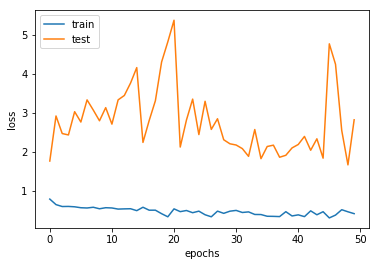

In [34]:
# plot loss and accuracy history 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.show()

In [35]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Testing: %.3f' % (train_acc, val_acc))

Train: 0.733, Testing: 0.667


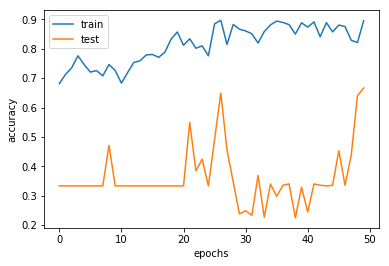

In [36]:
#plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend()
pyplot.show()

In [37]:
# show auc curve
y_pred = model.predict(X_test)
prob = model.predict_proba(X_test)
prob = prob[:,1]
y_true = y_test[:,1]
# calculate scores
ffe_auc = roc_auc_score(y_true, prob)
# summarize scores
print('ROC AUC=%.3f' % (ffe_auc))

ROC AUC=0.501


Text(0, 0.5, 'True Positive Rate')

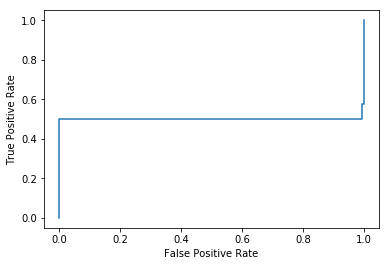

In [38]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, prob)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='-', label='FFE-LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

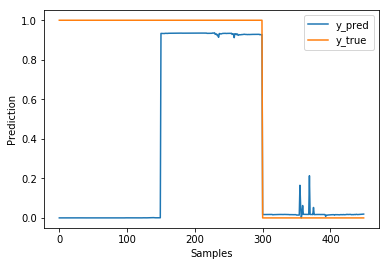

In [39]:
pyplot.plot(prob, label='y_pred')
pyplot.plot(y_true, label='y_true')
pyplot.legend()
pyplot.xlabel('Samples')
pyplot.ylabel('Prediction')
pyplot.show()


In [85]:
# Save predictions to csv with participant, mood, EAR, MAR
y_pred = pd.DataFrame(y_pred)

test_set = dataset[['participant','mood','eye_l_ratio','eye_r_ratio','mouth_ratio']]
test_set = test_set[train_size:X.shape[0]]
predictions = test_set[::20]
predictions['alert'] = y_pred[[0]].values
predictions['drowsy'] = y_pred[[1]].values
predictions.to_csv('prediction.csv')

/home/mounika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/mounika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
